Import packages

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import torchvision.models as models
from torchvision.models.video import mc3_18, MC3_18_Weights
from torchvision.transforms import Resize, Pad, Normalize, Compose, RandomHorizontalFlip, ColorJitter, RandomRotation, GaussianBlur
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

Install data (only do this if you do not have the dataset installed already)

In [1]:
!wget -O 20bnjester-v1-00.zip https://apigwx-aws.qualcomm.com/qsc/public/v1/api/download/software/dataset/AIDataset/Jester/20bnjester-v1-00
!wget -O 20bnjester-v1-01.zip https://apigwx-aws.qualcomm.com/qsc/public/v1/api/download/software/dataset/AIDataset/Jester/20bnjester-v1-01
!wget -O 20bnjester-v1-02.zip https://apigwx-aws.qualcomm.com/qsc/public/v1/api/download/software/dataset/AIDataset/Jester/20bnjester-v1-02

--2024-12-02 16:42:58--  https://apigwx-aws.qualcomm.com/qsc/public/v1/api/download/software/dataset/AIDataset/Jester/20bnjester-v1-00
Resolving apigwx-aws.qualcomm.com (apigwx-aws.qualcomm.com)... 18.66.147.21, 18.66.147.86, 18.66.147.120, ...
Connecting to apigwx-aws.qualcomm.com (apigwx-aws.qualcomm.com)|18.66.147.21|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10000000000 (9.3G) [binary/octet-stream]
Saving to: ‘20bnjester-v1-00.zip’

20bnjester-v1-00.zi  71%[=============>      ]   6.62G  18.6MB/s    in 5m 0s   

2024-12-02 16:47:59 (22.6 MB/s) - Connection closed at byte 7106814506. Retrying.

--2024-12-02 16:48:00--  (try: 2)  https://apigwx-aws.qualcomm.com/qsc/public/v1/api/download/software/dataset/AIDataset/Jester/20bnjester-v1-00
Connecting to apigwx-aws.qualcomm.com (apigwx-aws.qualcomm.com)|18.66.147.21|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 10000000000 (9.3G), 2893185494 (2.7G) remaining [binary

In [7]:
!cat 20bnjester-v1-00.zip 20bnjester-v1-01.zip 20bnjester-v1-02.zip | tar zx

Initialize the dataset class

In [2]:
class JesterDataset(Dataset):
    def __init__(self, data, data_path, num_frames=30, frame_size=(224, 224), mean=(0.43216, 0.394666, 0.37645), std=(0.22803, 0.22145, 0.216989)):
        self.data = data
        self.data_path = data_path
        self.num_frames = num_frames
        self.frame_size = frame_size
        self.normalize = Normalize(mean, std)
        self.augment = Compose([
            RandomHorizontalFlip(),
            ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            RandomRotation(degrees=15),
            GaussianBlur(kernel_size=(3, 3))
        ])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        video_id, label = self.data.iloc[i]
        video_folder = os.path.join(self.data_path, str(video_id))
        video_tensor = self.load_videos(video_folder)
        return video_tensor, label

    def resize_and_pad(self, frame):
        _, h, w = frame.shape
        target_h, target_w = self.frame_size

        # determines the new size by resizing one side to 224 and scaling the other size with it while maintaining aspect ratio
        if h < w:
            new_h = target_h
            new_w = int(w * (target_h / h))
        else:
            new_w = target_w
            new_h = int(h * (target_w / w))
        
        resize_transform = Resize([new_h, new_w], antialias=True)
        frame = resize_transform(frame)
        
        pad_height = target_h - new_h
        pad_width = target_w - new_w
        pad_top = pad_height // 2
        pad_bottom = pad_height - pad_top
        pad_left = pad_width // 2
        pad_right = pad_width - pad_left

        pad_transform = Pad((pad_left, pad_top, pad_right, pad_bottom), fill=0)
        frame = pad_transform(frame)
        
        return frame

    def load_videos(self, video_folder):
        frames = []
        for frame in sorted(os.listdir(video_folder)):
            original_frame = read_image(os.path.join(video_folder, frame))
            frame = self.resize_and_pad(original_frame)
            frame = self.augment(frame)
            frame = frame.float() / 255.0
            frame = self.normalize(frame)
            frames.append(frame)
        if len(frames) < self.num_frames:
            num_missing_frames = self.num_frames - len(frames)
            # take last frame and duplicate it to fill in missing frames
            frames.extend([frames[-1]] * num_missing_frames)
        elif len(frames) > self.num_frames:
            # uniformly choose frames to keep the features
            indices = torch.linspace(0, len(frames) - 1, self.num_frames, dtype=int)
            frames = [frames[i] for i in indices]
        video_tensor = torch.stack(frames).float() # convert to float because of mismatch with pretrained model weights
        video_tensor = video_tensor.permute(1, 0, 2, 3)
        return video_tensor

Initialize all the functions

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def create_label_encoding(labels_path):
    labels_df = pd.read_csv(labels_path, header=None)
    label_encoding = {label: idx for idx, label in enumerate(labels_df[0])}
    return label_encoding

def split_data(labels_path):
    label_encoding = create_label_encoding(labels_path)
    
    train_data = pd.read_csv('jester-v1-train.csv', sep=';', header=None)
    test_data = pd.read_csv('jester-v1-validation.csv', sep=';', header=None)

    train_data = train_data.sample(frac=0.005, random_state=42)
    test_data = test_data.sample(frac=0.05, random_state=42)
    val_data = test_data.sample(frac=0.5, random_state=42)
    test_data = test_data.drop(val_data.index) # remove validation data from testing data
    train_data[1] = train_data[1].map(label_encoding)
    val_data[1] = val_data[1].map(label_encoding)
    test_data[1] = test_data[1].map(label_encoding)
    
    return train_data, val_data, test_data

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_metrics = []
    val_metrics = []
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct_predictions = 0
        total = 0
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)

        for video, label in train_loader_tqdm:
            video = video.to(device)
            label = label.to(device)
            label_pred = model(video)
            loss = criterion(label_pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loader_tqdm.set_postfix(loss=loss.item())
            epoch_loss += loss.item()

            _, predicted_labels = torch.max(label_pred, 1)
            correct_predictions += (predicted_labels == label).sum().item()
            total += label.size(0)

        train_loss = epoch_loss / len(val_loader)
        train_accuracy = correct_predictions / total * 100

        val_loss, val_accuracy = validate(model, val_loader, criterion, device)
        train_metrics.append((train_loss, train_accuracy))
        val_metrics.append((val_loss, val_accuracy))
        print(f"""Epoch: {epoch + 1}, Train loss: {train_loss} with accuracy: {train_accuracy}
              Validation loss: {val_loss} with accuracy: {val_accuracy}""")
        model.train()

        if (epoch + 1) % 2 == 0:
            torch.save(model.state_dict(), f'model_{model.__class__.__name__}_{epoch + 1}.pth')

    train_losses = [metric[0] for metric in train_metrics]
    train_accuracies = [metric[1] for metric in train_metrics]

    val_losses = [metric[0] for metric in val_metrics]
    val_accuracies = [metric[1] for metric in val_metrics]

    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label='Train accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation accuracy', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"accuracy_{model.__class__.__name__}.png")
    plt.show()
    plt.close()

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train loss', marker='o')
    plt.plot(epochs, val_losses, label='Validation loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"loss_{model.__class__.__name__}.png")
    plt.show()
    plt.close()

def validate(model, val_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        correct_predictions = 0
        total = 0
        for video, label in val_loader:
            video = video.to(device)
            label = label.to(device)
            label_pred = model(video)
            loss = criterion(label_pred, label)
            total_loss += loss.item()

            _, predicted_labels = torch.max(label_pred, 1)
            correct_predictions += (predicted_labels == label).sum().item()
            total += label.size(0)

        avg_loss = total_loss / len(val_loader)
        accuracy = correct_predictions / total * 100
    return avg_loss, accuracy

def test(model, test_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        correct_predictions = 0
        total = 0
        for video, label in test_loader:
            video = video.to(device)
            label = label.to(device)
            label_pred = model(video)
            loss = criterion(label_pred, label)
            total_loss += loss.item()

            _, predicted_labels = torch.max(label_pred, 1)
            correct_predictions += (predicted_labels == label).sum().item()
            total += label.size(0)
        avg_loss = total_loss / len(test_loader)
        accuracy = correct_predictions / total * 100
    return avg_loss, accuracy

Run the training/validation

Train length: 593
Validation length: 370
Test length: 369
Made the Dataloaders


Epoch: 1, Train loss: 5.319869418298045 with accuracy: 7.251264755480608
              Validation loss: 3.2853096223646596 with accuracy: 6.486486486486487


Epoch: 2, Train loss: 5.048208826331682 with accuracy: 9.780775716694773
              Validation loss: 3.220777557742211 with accuracy: 7.567567567567568


Epoch: 3, Train loss: 4.747185817328832 with accuracy: 15.008431703204048
              Validation loss: 3.201441216212447 with accuracy: 10.0


Epoch: 4, Train loss: 4.48676707154961 with accuracy: 19.898819561551434
              Validation loss: 3.046580368472684 with accuracy: 14.864864864864865


Epoch: 5, Train loss: 4.216667491902587 with accuracy: 26.30691399662732
              Validation loss: 2.9878463604116954 with accuracy: 11.621621621621623


Epoch: 6, Train loss: 3.8907429005510066 with accuracy: 35.750421585160204
              Validation loss: 3.1774194919934837 with accuracy: 12.162162162162163


Epoch: 7, Train loss: 3.573973863355575 with accuracy: 45.86846543001686
              Validation loss: 3.173363813789942 with accuracy: 11.351351351351353


Epoch: 8, Train loss: 3.243276426869054 with accuracy: 51.93929173693086
              Validation loss: 2.999860537949429 with accuracy: 17.56756756756757


Epoch: 9, Train loss: 2.9067096620477657 with accuracy: 61.551433389544684
              Validation loss: 3.023146099941705 with accuracy: 14.324324324324325


Epoch: 10, Train loss: 2.6963450889433584 with accuracy: 67.79089376053963
              Validation loss: 2.9665241805456017 with accuracy: 18.10810810810811


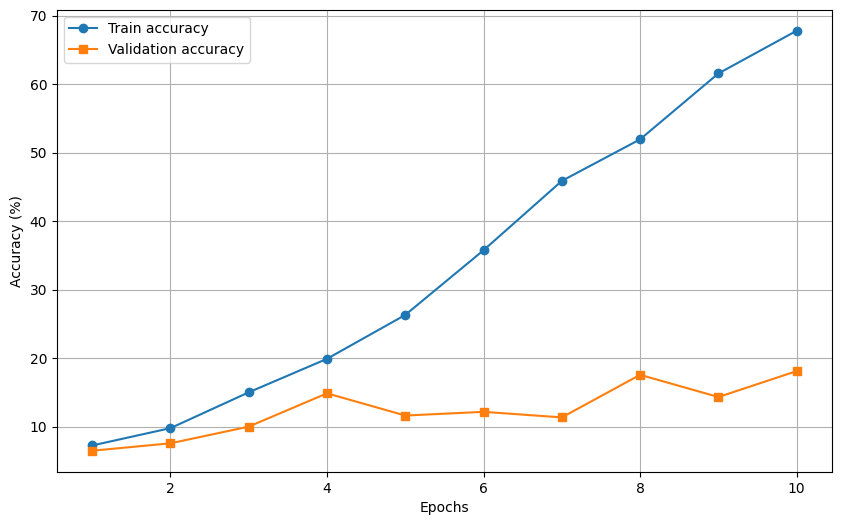

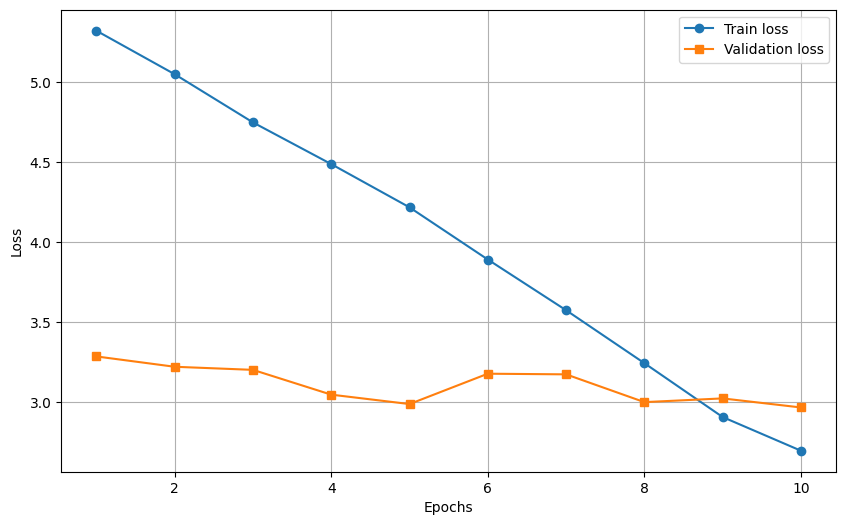

In [4]:
def main():
    seed = 42
    set_seed(seed)

    data_path = r'20bn-jester-v1'
    labels_path = 'jester-v1-labels.csv'

    train_data, val_data, test_data = split_data(labels_path)
    print(f"Train length: {len(train_data)}")
    print(f"Validation length: {len(val_data)}")
    print(f"Test length: {len(test_data)}")

    train_dataset = JesterDataset(train_data, data_path)
    val_dataset = JesterDataset(val_data, data_path)
    test_dataset = JesterDataset(test_data, data_path)

    batch_size = 4
    num_workers = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    print("Made the Dataloaders")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = mc3_18(weights=MC3_18_Weights.DEFAULT)

    
    output_size = len(set(train_data[1]))
    # change the output size of the pretrained model to match the number of classes in my dataset
    model.fc = torch.nn.Linear(model.fc.in_features, output_size)
    
    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)

    num_epochs = 10

    train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    test(model, test_loader, criterion, device)

if __name__ == '__main__':
    main()

In [6]:
seed = 42
set_seed(seed)

data_path = r'20bn-jester-v1'
labels_path = 'jester-v1-labels.csv'

label_encoding = create_label_encoding(labels_path)
output_size = len(label_encoding)

test_data = pd.read_csv('jester-v1-validation.csv', sep=';', header=None)
test_data = test_data.sample(frac=0.05, random_state=42)
test_data[1] = test_data[1].map(label_encoding)

test_dataset = JesterDataset(test_data, data_path)
batch_size = 4
num_workers = 16
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = mc3_18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, output_size)
model = model.to(device)

model.load_state_dict(torch.load('model1_10.pth', map_location=device))

criterion = torch.nn.CrossEntropyLoss()

test_loss, accuracy = test(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')



Test Loss: 3.0278, Test Accuracy: 16.91%


Model 2

In [4]:
def split_data(labels_path):
    label_encoding = create_label_encoding(labels_path)
    
    train_data = pd.read_csv('jester-v1-train.csv', sep=';', header=None)
    test_data = pd.read_csv('jester-v1-validation.csv', sep=';', header=None)

    train_data = train_data.sample(frac=0.030, random_state=42)
    test_data = test_data.sample(frac=0.05, random_state=42)
    val_data = test_data.sample(frac=0.5, random_state=42)
    test_data = test_data.drop(val_data.index) # remove validation data from testing data
    train_data[1] = train_data[1].map(label_encoding)
    val_data[1] = val_data[1].map(label_encoding)
    test_data[1] = test_data[1].map(label_encoding)
    
    return train_data, val_data, test_data

Train length: 3557
Validation length: 370
Test length: 369
Made the Dataloaders


Epoch: 1, Train loss: 27.36852897623534 with accuracy: 16.84003373629463
              Validation loss: 2.506886789875646 with accuracy: 24.324324324324326


Epoch: 2, Train loss: 19.148175746522924 with accuracy: 38.74051166713522
              Validation loss: 1.8205522981382185 with accuracy: 42.432432432432435


Epoch: 3, Train loss: 14.651846827358328 with accuracy: 53.92184425077312
              Validation loss: 2.3127492672653607 with accuracy: 39.45945945945946


Epoch: 4, Train loss: 12.20547614591096 with accuracy: 61.34382906944054
              Validation loss: 1.7132944337953564 with accuracy: 49.45945945945946


Epoch: 5, Train loss: 9.984926644993084 with accuracy: 68.48467809952207
              Validation loss: 1.4491751132312642 with accuracy: 55.67567567567567


Epoch: 6, Train loss: 8.586259580427601 with accuracy: 73.48889513635086
              Validation loss: 1.3038148188472836 with accuracy: 59.72972972972973


Epoch: 7, Train loss: 7.597345731912121 with accuracy: 75.51307281416925
              Validation loss: 1.5159114163408998 with accuracy: 55.945945945945944


Epoch: 8, Train loss: 6.794019628506434 with accuracy: 78.54933933089683
              Validation loss: 1.3527232077553548 with accuracy: 60.0


Epoch: 9, Train loss: 6.589131900139393 with accuracy: 79.33651953893731
              Validation loss: 1.6087566980871784 with accuracy: 56.21621621621622


Epoch: 10, Train loss: 5.425697134367081 with accuracy: 83.38487489457408
              Validation loss: 1.2108497153366766 with accuracy: 66.21621621621621


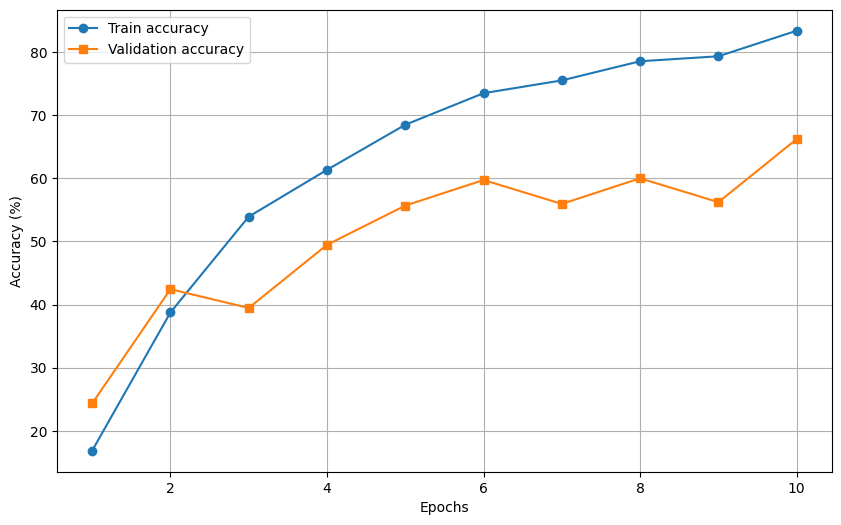

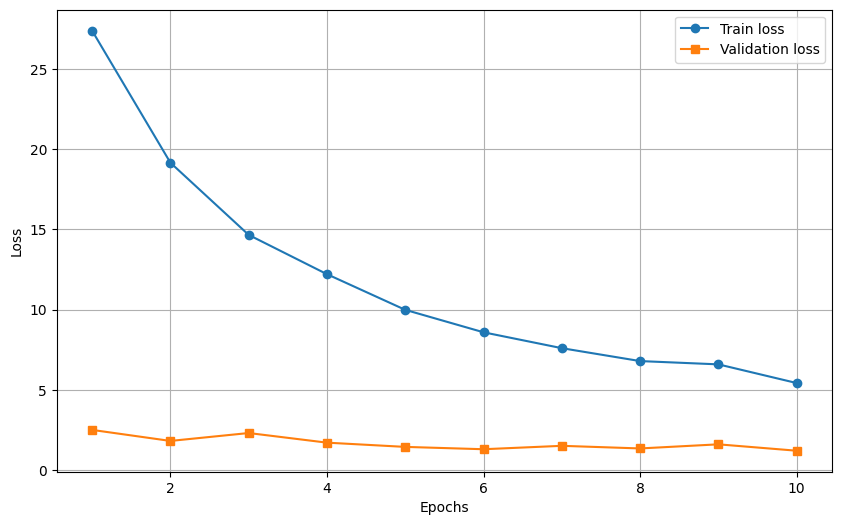

In [5]:
def main():
    seed = 42
    set_seed(seed)

    data_path = r'20bn-jester-v1'
    labels_path = 'jester-v1-labels.csv'

    train_data, val_data, test_data = split_data(labels_path)
    print(f"Train length: {len(train_data)}")
    print(f"Validation length: {len(val_data)}")
    print(f"Test length: {len(test_data)}")

    train_dataset = JesterDataset(train_data, data_path)
    val_dataset = JesterDataset(val_data, data_path)
    test_dataset = JesterDataset(test_data, data_path)

    batch_size = 4
    num_workers = 16
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    print("Made the Dataloaders")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = models.video.s3d(weights=models.video.S3D_Weights.DEFAULT)

    
    output_size = len(set(train_data[1]))
    # change the output size of the pretrained model to match the number of classes in my dataset
    model.classifier = torch.nn.Conv3d(
        in_channels=1024,  # Feature size from S3D
        out_channels=output_size,
        kernel_size=(1, 1, 1),
        stride=(1, 1, 1)
    )
    
    model = model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)

    num_epochs = 10

    train(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)
    test(model, test_loader, criterion, device)

if __name__ == '__main__':
    main()